<a href="https://colab.research.google.com/github/rishipython/ALL-Cell-Classification/blob/main/LeukemiaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.layers import Add
from keras.layers import Dense
from keras import backend as K
from keras.engine import Input, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, PReLU, Dropout, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.utils import to_categorical
import PIL
import numpy as np
from PIL import Image
from numpy import asarray
import glob
import nibabel as nib
import os
import tarfile as trf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score, roc_curve, auc
from IPython.display import display
K.set_image_data_format("channels_last")

In [ ]:
# Access GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 12 16:29:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Access more memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# See if Tensorflow is using GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_dir = f"{os.sep}content{os.sep}drive{os.sep}My Drive{os.sep}leukemia_classification{os.sep}"

In [ ]:
ls "/content/drive/My Drive/leukemia_classification/"

history_1.csv  history_4.csv  model_2/  std.txt      x_val.npy    y_val.npy
history_2.csv  mean.txt       model_3/  x_test.npy   y_test.npy
history_3.csv  model_1/       model_4/  x_train.npy  y_train.npy


# Get data
After this section is run, the LeukemiaClassificationDataPreprocessing notebook (https://colab.research.google.com/drive/1krgFYd9DxSylUix4kwPNwN15W4cMeWr5?usp=sharing) should be ran. After that, this section shouldn't need to be run again.

In [ ]:
# Get image as numpy array from path
def get_img_from_path(path):
  image = Image.open(path)
  return asarray(image)

In [ ]:
# Get folders and files
folders = [{subfolder[-3:]:[file for file in glob.glob(subfolder+"/*")] for subfolder in glob.glob(folder+"/*")} for folder in [drive_dir+f"fold_{i}" for i in range(3)]]

In [ ]:
print(folders)

[{'all': ['/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_23_5_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_24_3_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_23_1_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_24_4_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_24_1_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_33_4_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_29_6_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_33_9_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_28_9_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_29_9_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_29_3_all.bmp', '/content/drive/My Drive/leukemia_classification/fold_0/all/UID_48_33_7_all.bmp', '/cont

In [ ]:
files = []
y = []

In [ ]:
# Get files and labels
for folder in folders:
  for file in folder['all']:
    y.append(1)
    files.append(file)
  for file in folder['hem']:
    y.append(0)
    files.append(file)

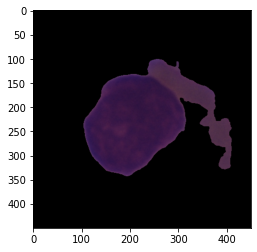

In [ ]:
plt.imshow(get_img_from_path(files[0]))

In [ ]:
# Get image i as numpy array
def get_img(i):
  return get_img_from_path(files[i])

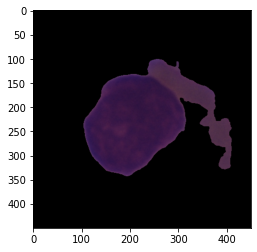

In [ ]:
plt.imshow(get_img(0))

In [ ]:
# Plot image
def plot_img(i):
  plt.imshow(get_img(i))

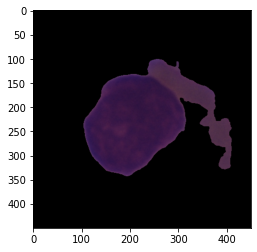

In [ ]:
plot_img(0)

In [ ]:
# Number of files
n = len(files)

In [ ]:
print(f"Number of files: {n}")

Number of files: 10661


In [ ]:
x = []

In [ ]:
# Get images and label as numpy array
"""
for i in range(len(files)):
  x.append(get_img(i))
  y[i] = np.array(y[i])
  for j in range(2):
    y[i] = np.expand_dims(y[i], axis=0)
  print(f"{i+1}/{n}")
y = np.expand_dims(y, axis=3)
print("Task complete! :)")
"""

'\nfor i in range(len(files)):\n  x.append(get_img(i))\n  y[i] = np.array(y[i])\n  for j in range(2):\n    y[i] = np.expand_dims(y[i], axis=0)\n  print(f"{i+1}/{n}")\ny = np.expand_dims(y, axis=3)\nprint("Task complete! :)")\n'

In [ ]:
"""
x = np.array(x)
y = np.array(y)
"""

'\nx = np.array(x)\ny = np.array(y)\n'

In [ ]:
# print(x.shape)

In [ ]:
# print(y.shape)

In [ ]:
"""
np.save(drive_dir + "images.npy", x)
np.save(drive_dir + "labels.npy", y)
"""

'\nnp.save(drive_dir + "images.npy", x)\nnp.save(drive_dir + "labels.npy", y)\n'

In [ ]:
# Note: Data preprocessing is done in this notebook: https://colab.research.google.com/drive/1krgFYd9DxSylUix4kwPNwN15W4cMeWr5?usp=sharing

# Model Evaluation

In [ ]:
num_models = 4 # Number of models being evaluated

In [ ]:
models = []
histories = []

In [ ]:
for i in range(num_models):
  models.append(keras.models.load_model(drive_dir+f"model_{i+1}"))
  histories.append(pd.read_csv(drive_dir+f"history_{i+1}.csv"))

In [ ]:
print(len(models)) # should be equal to num_models
print(len(histories)) # should be equal to num_models

4
4


In [ ]:
# Load cross validation dataset
x_val = np.load(drive_dir+"x_val.npy")
y_val = np.load(drive_dir+"y_val.npy")

In [ ]:
classes = {0: "Healthy", 1: "ALL"}
n_labels = 2

In [ ]:
eval_metrics = "TP	TN	FP	FN	Accuracy	Prevalence	Sensitivity	Specificity	PPV	NPV	AUC	F1	Threshold".split()
print(eval_metrics)

['TP', 'TN', 'FP', 'FN', 'Accuracy', 'Prevalence', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC', 'F1', 'Threshold']


In [ ]:
# Functions to get true positives, true negatives, false positives, and false negatives
def true_positives(y, pred, th=0.5):
  thresholded_preds = pred > th    
  TP = np.sum((y == 1) & (thresholded_preds == 1))
  return TP

def true_negatives(y, pred, th=0.5):
  thresholded_preds = pred > th
  TN = np.sum((y == 0) & (thresholded_preds == 0))
  return TN

def false_positives(y, pred, th=0.5):
  thresholded_preds = pred > th
  FP = np.sum((y == 0) & (thresholded_preds == 1))
  return FP

def false_negatives(y, pred, th=0.5):
  thresholded_preds = pred > th
  FN = np.sum((y == 1) & (thresholded_preds == 0))
  return FN

In [ ]:
# Function to get the accuracy
def get_accuracy(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  TN = true_negatives(y, pred, th)
  FN = false_negatives(y, pred, th)
  accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
  return accuracy

In [ ]:
# Function to get the prevalence
def get_prevalence(y, type):
  prevalence = np.mean(y==type)
  return prevalence

In [ ]:
testarr = np.array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0]) # Numpy array to test get_prevalence function

In [ ]:
print(get_prevalence(testarr, 0)) # shoudl output 0.6
print(get_prevalence(testarr, 1)) # should output 0.4

0.6
0.4


In [ ]:
# Function to get the sensitivity
def get_sensitivity(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  sensitivity = TP / (TP + FN + epsilon)
  return sensitivity

In [ ]:
# Function to get the specificity
def get_specificity(y, pred, th=0.5, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th) 
    specificity = TN / (TN + FP + epsilon)
    return specificity

In [ ]:
# Function to get the ppv
def get_ppv(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  PPV = TP / (TP + FP + epsilon)
  return PPV

In [ ]:
# Function to get the npv
def get_npv(y, pred, th=0.5, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    NPV = TN / (TN + FN + epsilon)
    return NPV

In [ ]:
def get_f1_score(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  f1_score = TP/(TP + 0.5 * (FP + FN) + epsilon)
  return f1_score

In [ ]:
# Function to plot the roc curve
def plotROCCurve(j, y, x, n_labels=n_labels):
  model = models[j]
  pred = model.predict(x)
  fpr, tpr, _ = roc_curve(y[:, :, :, 0].flatten(), pred[:, :, :, 0].flatten())
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr,
          lw=2, label=f'ROC curve for class {classes[1]} (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating characteristic curve for model_{j+1}')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Function to plot history
def plotHistory(key, ylabel, xlabel="Epochs"):
  lines = []
  for i in range(num_models):
    line, = plt.plot(histories[i][key], label=f"model_{i+1}")
    lines.append(line)
  plt.legend(handles=lines)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

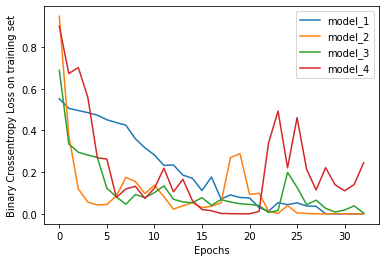

In [ ]:
# Plot history of binary crossentropy loss on training set (lower loss = better)
plotHistory("loss", "Binary Crossentropy Loss on training set")

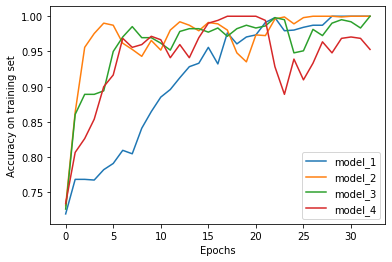

In [ ]:
# Plot history of accuracy on training set (higher accuracy = better)
plotHistory("accuracy", "Accuracy on training set")

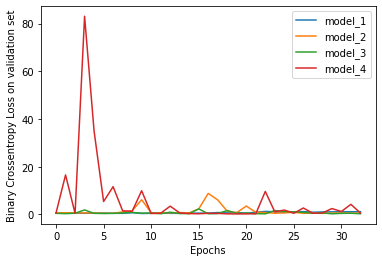

In [ ]:
# Plot history of binary crossentropy loss on validation set (lower loss = better)
plotHistory("val_loss", "Binary Crossentropy Loss on validation set")

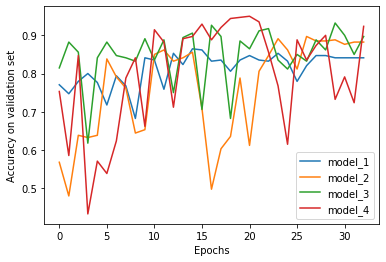

In [ ]:
# Plot history of accuracy on training set (higher accuracy = better)
plotHistory("val_accuracy", "Accuracy on validation set")

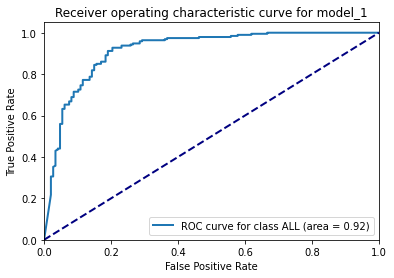

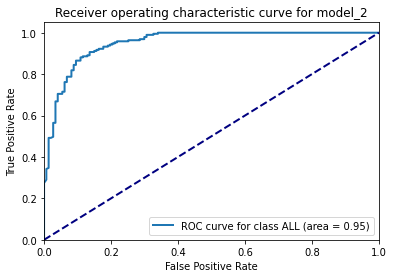

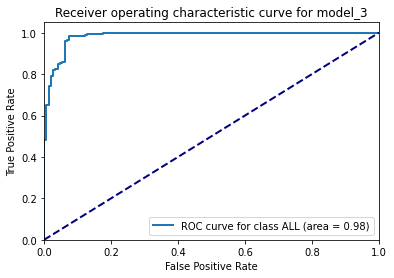

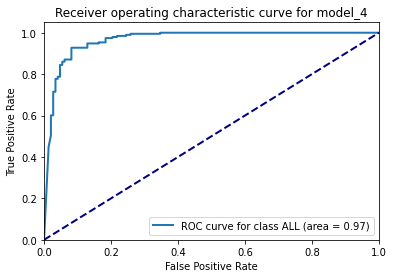

In [ ]:
# Plot ROC curves for each model
for i in range(num_models):
  plotROCCurve(i, y_val, x_val, n_labels=n_labels)

In [ ]:
evaluations = [{metric:{tumor_class:None for tumor_class in classes.values()} for metric in eval_metrics} for i in range(num_models)]

In [ ]:
for i in range(num_models):
  pred = models[i].predict(x_val)
  for j in range(n_labels):
    if j == 0:
      TP = true_positives(1-y_val, 1-pred)
      TN = true_negatives(1-y_val, 1-pred)
      FP = false_positives(1-y_val, 1-pred)
      FN = false_negatives(1-y_val, 1-pred)
      accuracy = get_accuracy(1-y_val, 1-pred)
      prevalence = get_prevalence(y_val, j)
      sensitivity = get_sensitivity(1-y_val, 1-pred)
      specificity = get_specificity(1-y_val, 1-pred)
      ppv = get_ppv(1-y_val, 1-pred)
      npv = get_npv(1-y_val, 1-pred)
      auc_value = roc_auc_score((1-y_val).flatten(), (1-pred).flatten())
      f1_score = get_f1_score(1-y_val, 1-pred)
    else:
      TP = true_positives(y_val, pred)
      TN = true_negatives(y_val, pred)
      FP = false_positives(y_val, pred)
      FN = false_negatives(y_val, pred)
      accuracy = get_accuracy(y_val, pred)
      prevalence = get_prevalence(y_val, j)
      sensitivity = get_sensitivity(y_val, pred)
      specificity = get_specificity(y_val, pred)
      ppv = get_ppv(y_val, pred)
      npv = get_npv(y_val, pred)
      auc_value = roc_auc_score(y_val.flatten(), pred.flatten())
      f1_score = get_f1_score(y_val, pred)

    evaluations[i]["TP"][classes[j]] = TP
    evaluations[i]["TN"][classes[j]] = TN
    evaluations[i]["FP"][classes[j]] = FP
    evaluations[i]["FN"][classes[j]] = FN
    evaluations[i]["Accuracy"][classes[j]] = accuracy
    evaluations[i]["Prevalence"][classes[j]] = prevalence
    evaluations[i]["Sensitivity"][classes[j]] = sensitivity
    evaluations[i]["Specificity"][classes[j]] = specificity
    evaluations[i]["PPV"][classes[j]] = ppv
    evaluations[i]["NPV"][classes[j]] = npv
    evaluations[i]["AUC"][classes[j]] = auc_value
    evaluations[i]["F1"][classes[j]] = f1_score
    evaluations[i]["Threshold"][classes[j]] = 0.5

In [ ]:
dfs = [pd.DataFrame(data=evaluations[i]) for i in range(num_models)]

In [ ]:
for i in range(num_models):
  print(f"model_{i+1}:")
  display(dfs[i])

model_1:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Healthy,125,161,32,22,0.841176,0.432353,0.850340,0.834197,0.796178,0.879781,0.912745,0.822368,0.5
ALL,161,125,22,32,0.841176,0.567647,0.834197,0.850340,0.879781,0.796178,0.915195,0.856383,0.5


model_2:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Healthy,127,173,20,20,0.882353,0.432353,0.863946,0.896373,0.863946,0.896373,0.951482,0.863946,0.5
ALL,173,127,20,20,0.882353,0.567647,0.896373,0.863946,0.896373,0.863946,0.951482,0.896373,0.5


model_3:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Healthy,139,166,27,8,0.897059,0.432353,0.945578,0.860104,0.837349,0.954023,0.983962,0.888179,0.5
ALL,166,139,8,27,0.897059,0.567647,0.860104,0.945578,0.954023,0.837349,0.983962,0.904632,0.5


model_4:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Healthy,135,179,14,12,0.923529,0.432353,0.918367,0.927461,0.906040,0.937173,0.963977,0.912162,0.5
ALL,179,135,12,14,0.923529,0.567647,0.927461,0.918367,0.937173,0.906040,0.965634,0.932292,0.5


In [ ]:
def group_bar_graph(metric, ylabel=None, title=None, width=0.4, ndigits=4):
  if ylabel == None:
    ylabel = metric
  if title == None:
    title = f"{metric} for all models"

  healthy = []
  all = []
  for i in range(num_models):
    healthy.append(dfs[i][metric][0])
    all.append(dfs[i][metric][1])

  locs = np.arange(num_models)

  fig, ax = plt.subplots()
  rects1 = ax.bar(locs - width/2, healthy, width, label='Healthy')
  rects2 = ax.bar(locs + width/2, all, width, label='ALL')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.set_xticks(locs)
  ax.set_xticklabels([f"model_{i+1}" for i in range(num_models)])
  ax.legend(loc="lower right")

  for rect in rects1:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, ndigits)), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
  for rect in rects2:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, ndigits)), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

  fig.tight_layout()

  plt.show()

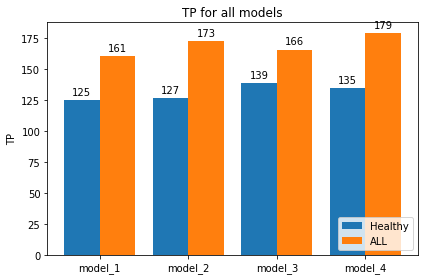

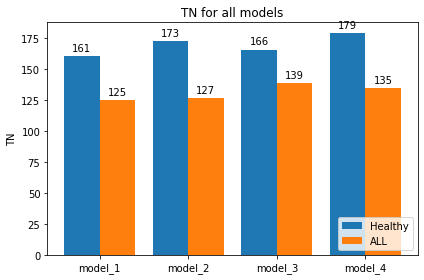

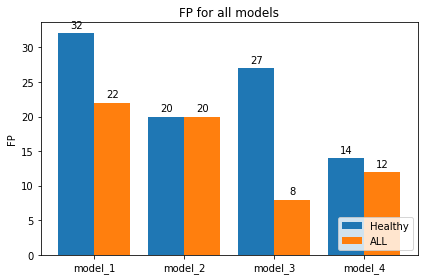

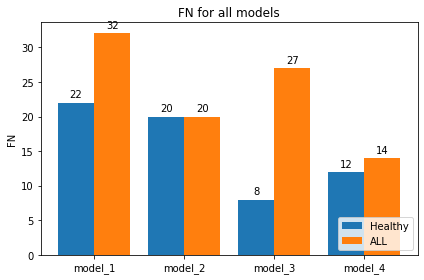

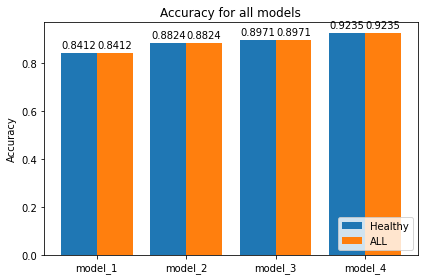

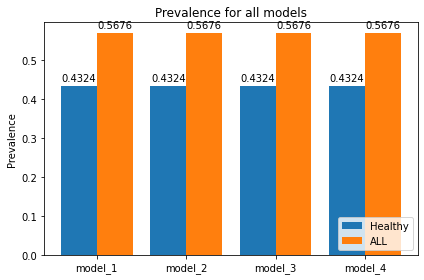

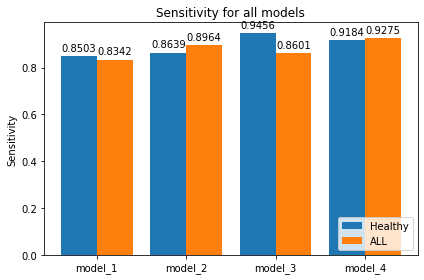

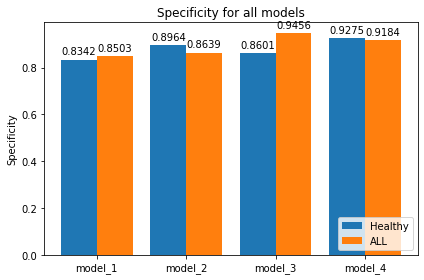

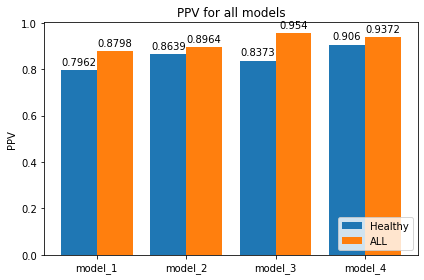

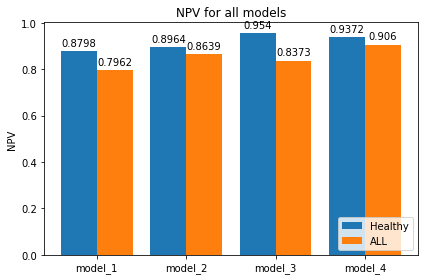

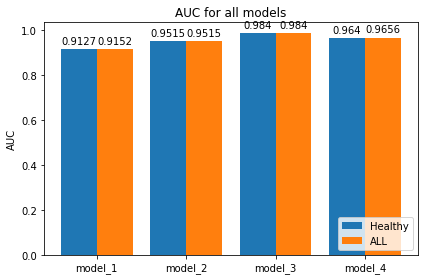

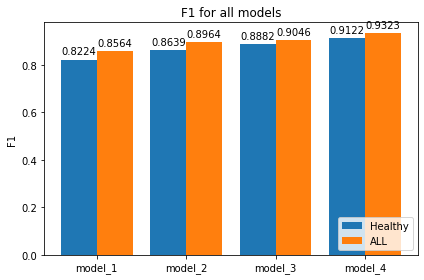

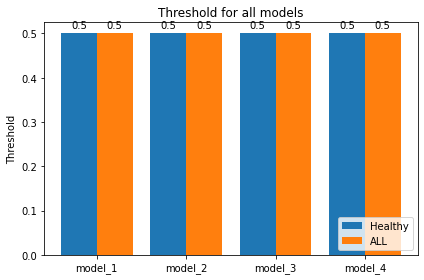

In [ ]:
for metric in eval_metrics:
  group_bar_graph(metric)

In [ ]:
def mean_bar_graph(metric, ylabel=None, title=None, width=0.4, ndigits=4):
  if ylabel == None:
    ylabel = metric
  if title == None:
    title = f"{metric} for all models"

  mean = []
  for i in range(num_models):
    healthy = dfs[i][metric][0]
    all = dfs[i][metric][1]
    mean.append((healthy+all)/2.0)

  locs = np.arange(num_models)

  fig, ax = plt.subplots()
  rects = ax.bar(locs - width/2, mean, width, label='Mean')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.set_xticks(locs)
  ax.set_xticklabels([f"model_{i+1}" for i in range(num_models)])
  ax.legend(loc="lower right")

  for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, ndigits)), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

  fig.tight_layout()

  plt.show()

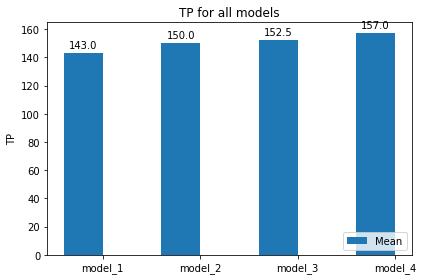

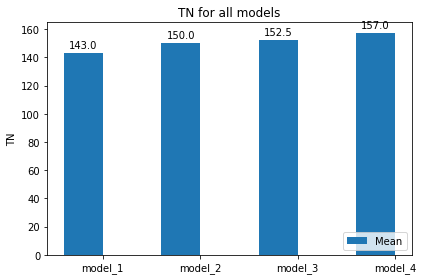

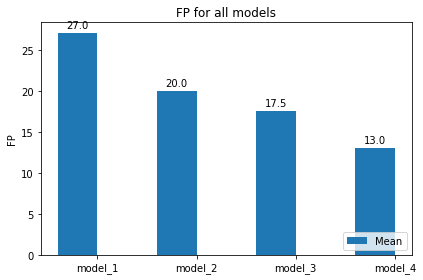

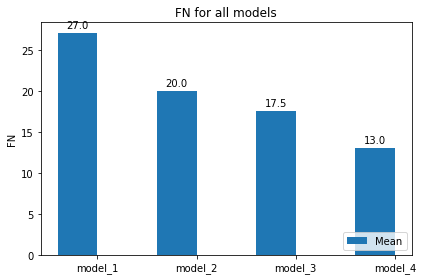

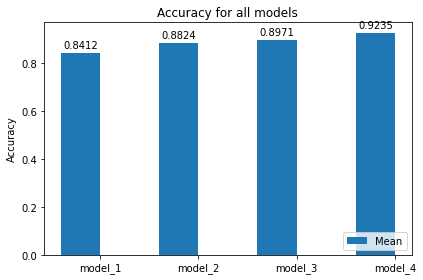

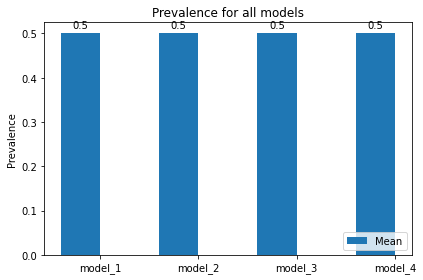

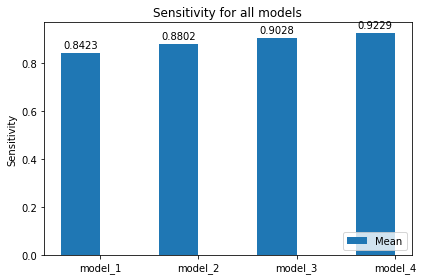

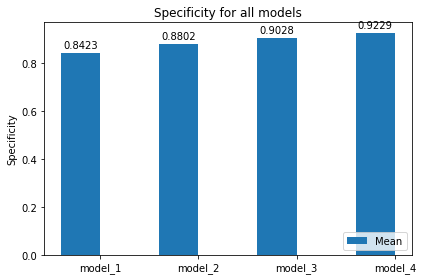

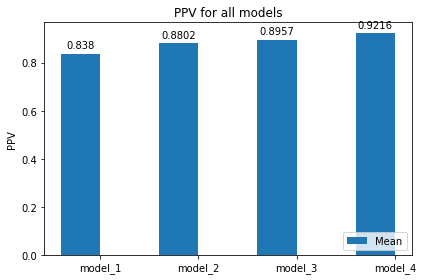

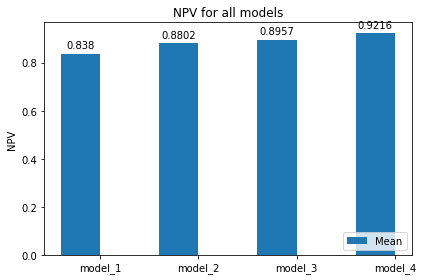

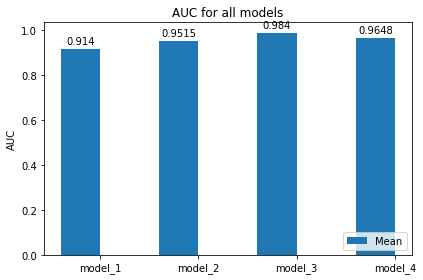

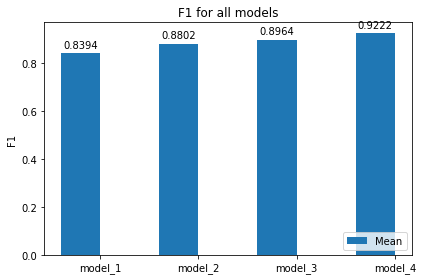

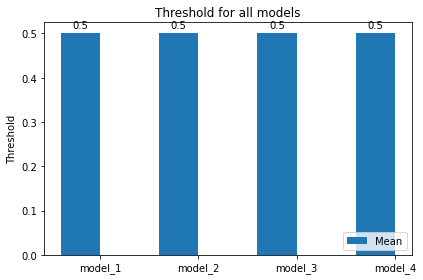

In [ ]:
for metric in eval_metrics:
  mean_bar_graph(metric)

# Evaluate best model on test data

In [ ]:
best_model = "model_4" # based on the performance of the models on the cross validation data, model_4 was determined to be the best model

In [ ]:
model = keras.models.load_model(drive_dir+best_model)

In [ ]:
x_test = np.load(drive_dir+"x_test.npy")
y_test = np.load(drive_dir+"y_test.npy")

In [ ]:
classes = {0: "Healthy", 1: "ALL"}
n_labels = 2

In [ ]:
eval_metrics = "TP	TN	FP	FN	Accuracy	Prevalence	Sensitivity	Specificity	PPV	NPV	AUC	F1	Threshold".split()
print(eval_metrics)

['TP', 'TN', 'FP', 'FN', 'Accuracy', 'Prevalence', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUC', 'F1', 'Threshold']


In [ ]:
# Functions to get true positives, true negatives, false positives, and false negatives
def true_positives(y, pred, th=0.5):
  thresholded_preds = pred > th    
  TP = np.sum((y == 1) & (thresholded_preds == 1))
  return TP

def true_negatives(y, pred, th=0.5):
  thresholded_preds = pred > th
  TN = np.sum((y == 0) & (thresholded_preds == 0))
  return TN

def false_positives(y, pred, th=0.5):
  thresholded_preds = pred > th
  FP = np.sum((y == 0) & (thresholded_preds == 1))
  return FP

def false_negatives(y, pred, th=0.5):
  thresholded_preds = pred > th
  FN = np.sum((y == 1) & (thresholded_preds == 0))
  return FN

In [ ]:
# Function to get the accuracy
def get_accuracy(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  TN = true_negatives(y, pred, th)
  FN = false_negatives(y, pred, th)
  accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
  return accuracy

In [ ]:
# Function to get the prevalence
def get_prevalence(y, type):
  prevalence = np.mean(y==type)
  return prevalence

In [ ]:
# Function to get the sensitivity
def get_sensitivity(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  sensitivity = TP / (TP + FN + epsilon)
  return sensitivity

In [ ]:
# Function to get the specificity
def get_specificity(y, pred, th=0.5, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th) 
    specificity = TN / (TN + FP + epsilon)
    return specificity

In [ ]:
# Function to get the ppv
def get_ppv(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  PPV = TP / (TP + FP + epsilon)
  return PPV

In [ ]:
# Function to get the npv
def get_npv(y, pred, th=0.5, epsilon=1e-100):
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    NPV = TN / (TN + FN + epsilon)
    return NPV

In [ ]:
def get_f1_score(y, pred, th=0.5, epsilon=1e-100):
  TP = true_positives(y, pred, th)
  FP = false_positives(y, pred, th)
  FN = false_negatives(y, pred, th)
  f1_score = TP/(TP + 0.5 * (FP + FN) + epsilon)
  return f1_score

In [ ]:
# Function to plot the roc curve
def test_plotROCCurve(y, x, n_labels=n_labels):
  pred = model.predict(x)
  fpr, tpr, _ = roc_curve(y[:, :, :, 0].flatten(), pred[:, :, :, 0].flatten())
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr,
          lw=2, label=f'ROC curve for class {classes[1]} (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating characteristic curve for {best_model}')
  plt.legend(loc="lower right")
  plt.show()

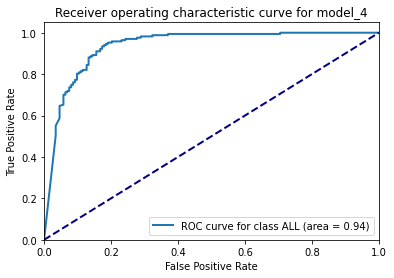

In [ ]:
test_plotROCCurve(y_test, x_test, n_labels=n_labels)

In [ ]:
test_evaluations = {metric:{tumor_class:None for tumor_class in classes.values()} for metric in eval_metrics}

In [ ]:
pred = model.predict(x_test)
for j in range(n_labels):
  if j == 0:
    TP = true_positives(1-y_test, 1-pred)
    TN = true_negatives(1-y_test, 1-pred)
    FP = false_positives(1-y_test, 1-pred)
    FN = false_negatives(1-y_test, 1-pred)
    accuracy = get_accuracy(1-y_test, 1-pred)
    prevalence = get_prevalence(y_test, j)
    sensitivity = get_sensitivity(1-y_test, 1-pred)
    specificity = get_specificity(1-y_test, 1-pred)
    ppv = get_ppv(1-y_test, 1-pred)
    npv = get_npv(1-y_test, 1-pred)
    auc_value = roc_auc_score((1-y_test).flatten(), (1-pred).flatten())
    f1_score = get_f1_score(1-y_test, 1-pred)
  else:
    TP = true_positives(y_test, pred)
    TN = true_negatives(y_test, pred)
    FP = false_positives(y_test, pred)
    FN = false_negatives(y_test, pred)
    accuracy = get_accuracy(y_test, pred)
    prevalence = get_prevalence(y_test, j)
    sensitivity = get_sensitivity(y_test, pred)
    specificity = get_specificity(y_test, pred)
    ppv = get_ppv(y_test, pred)
    npv = get_npv(y_test, pred)
    auc_value = roc_auc_score(y_test.flatten(), pred.flatten())
    f1_score = get_f1_score(y_test, pred)

  test_evaluations["TP"][classes[j]] = TP
  test_evaluations["TN"][classes[j]] = TN
  test_evaluations["FP"][classes[j]] = FP
  test_evaluations["FN"][classes[j]] = FN
  test_evaluations["Accuracy"][classes[j]] = accuracy
  test_evaluations["Prevalence"][classes[j]] = prevalence
  test_evaluations["Sensitivity"][classes[j]] = sensitivity
  test_evaluations["Specificity"][classes[j]] = specificity
  test_evaluations["PPV"][classes[j]] = ppv
  test_evaluations["NPV"][classes[j]] = npv
  test_evaluations["AUC"][classes[j]] = auc_value
  test_evaluations["F1"][classes[j]] = f1_score
  test_evaluations["Threshold"][classes[j]] = 0.5

In [ ]:
df = pd.DataFrame(data=test_evaluations)

In [ ]:
print(f"{best_model}:")
display(df)

model_4:


,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
Healthy,146,149,18,27,0.867647,0.508824,0.843931,0.892216,0.890244,0.846591,0.934651,0.866469,0.5
ALL,149,146,27,18,0.867647,0.491176,0.892216,0.843931,0.846591,0.890244,0.936209,0.868805,0.5


In [ ]:
mean = 1
std = 1
with open(drive_dir+"mean.txt", 'r') as f:
  lines = f.readlines()
  mean = float(lines[0])
  f.close()
with open(drive_dir+"std.txt", 'r') as f:
  lines = f.readlines()
  std = float(lines[0])
  f.close()

In [ ]:
print(mean)
print(std)

9.178323056564189
23.645296284294893


Randomly chosen MRI scan index: 49


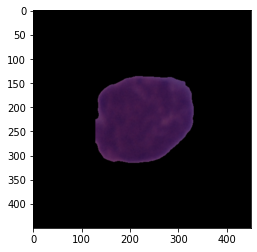

Predicted value: ALL (100.0%)
Actual value: ALL


In [ ]:
idx = np.random.randint(low=0, high=x_test.shape[0])
print(f"Randomly chosen MRI scan index: {idx}")
MRIscan = (x_test[idx, :, :, :]*std)+mean
MRIscan = MRIscan/255.0
plt.imshow(MRIscan)
plt.show()
inputMRIscan = np.array([x_test[idx]])
pred = model.predict(inputMRIscan).flatten()[0]
actual = y_test[idx, :, :, :]
print(f"Predicted value: {classes[pred>=0.5]} ({pred*100*(pred>=0.5) + (1-pred)*100*(pred<0.5)}%)")
print(f"Actual value: {classes[actual.flatten()[0]]}")